# Fields of the World: Country-Scale Field Boundary Predictions

Country-scale Sentinel-2 mosaics and AI-derived field boundary probability maps for Japan, Mexico, Rwanda, South Africa, and Switzerland.

This tutorial explains how to access cloud-native Zarr datasets generated during evaluation of FTW Phase 2 Model Bakeoff models on the Wherobots RasterFlow platform. It includes input imagery (seasonal mosaics) and raw model outputs (softmax predictions).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fieldsoftheworld/iclr2026-ml4rs-tutorial/blob/main/2.0-country-scale-field-boundary-predictions.ipynb)

<a name="software-requirements"></a>
# 💻 Software Requirements

This notebook requires Python (>= 3.12 and < 3.14) and an environment to run Jupyter notebooks.

All requirements can be installed through `pip` by running:
```bash
pip install .
```

If you are using Conda, we provide a lightweight environment file `environment.yml`. You can install it by running:
```bash
# Install environment
conda env create -f environment.yml
# Activate environment
conda activate ftw-tutorial
```

<!--

All tutorial submissions must have a separate `requirements.txt` file stating all dependencies and versions for software, packages, or tooling used in the tutorial. This file allows tutorial users who would like to run a copy of the notebook locally with all dependencies needed to create their own virtual environment/IPython kernel.

In bash you may create a `requirements.txt` by typing the following command:

`pip freeze > requirements.txt'

Avoid undocumented dependencies.

We encourage explicitly printing out your dependencies using a notebook extension such as [watermark](https://github.com/rasbt/watermark) at the bottom of your notebook.

Within the notebook, there must be a cell which includes the necessary directory structure to retrieve files or data using relative paths for ease of use. If data is private, please provide a similar public sample for those that would like to reproduce or extend your work. Instructions and imports with versioning must be provided and clearly labeled at the top.

Document the beginning and end date of your analysis to contextualize the development stage of the notebook in the event that highlighted packages or content is updated in the future.
-->

In [7]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = (
    "TRUE"  # when multiple copies of OpenMP are found we get a warning, this silences it
)

os.makedirs("data", exist_ok=True)

# If you have GDAL installed in your environment, these environment variables can cause issues
# with rasterio and fiona. So we unset them here.
for entry in ["GDAL_DATA", "PROJ_NETWORK", "PROJ_DATA", "GDAL_DRIVER_PATH"]:
    if entry in os.environ:
        del os.environ[entry]

# If the notebook was opened in Colab then clone the source repo and install required packages
if "google.colab" in str(get_ipython()):
    !git clone https://github.com/fieldsoftheworld/iclr2026-ml4rs-tutorial.git
    os.chdir("iclr2026-ml4rs-tutorial")

    !pip install .

## Dataset Coverage

The dataset covers five agricultural systems across two seasons and two years (2023 and 2024), totaling 4.76 million square kilometers. This data represents the inference stage of models produced during the FTW Phase 2 Model Bakeoff.

| Country | Area Processed (M sq km) | Median Prediction Field Area (ha) |
| :-- | :-- | :-- |
| Mexico | 2.39 | 0.09 |
| South Africa | 1.60 | 0.07 |
| Japan | 0.65 | 0.19 |
| Switzerland | 0.09 | 0.28 |
| Rwanda | 0.02 | 0.06 |

## Data Structure (Zarr)

The data is hosted as cloud-optimized Zarr stores. Each store corresponds to a country and contains high-resolution raster arrays with time coordinates for 2023 and 2024:

1. Sentinel-2 mosaics
   - Bi-temporal composites (Planting and Harvest seasons)
   - Resolution: 10m
   - Bands: RGB + NIR
   - Valid-pixel composites filtered by cloud cover

2. Model predictions
   - Raw softmax probabilities for background, field, and field boundary
   - Raw logits support custom thresholding, watershedding, or vectorization parameters

## Usage (Data Access)

The dataset uses cloud-native Zarr format, which allows access to subsets for analysis without downloading the entire dataset using Python libraries like xarray and zarr.

### 1. Setup and Define AOI

Define a sample area of interest (AOI) over Japan.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import xarray as xr

src_crs = "EPSG:3857"
planting_bands = ["s2med_planting:B04", "s2med_planting:B03", "s2med_planting:B02"]
harvest_bands = ["s2med_harvest:B04", "s2med_harvest:B03", "s2med_harvest:B02"]
norm = 3000

# Define a bounding box (Japan)
xmin, ymin = (140.029187, 39.520088)
xmax, ymax = (140.403203, 39.215519)
box = shapely.box(xmin, ymin, xmax, ymax)
aoi = gpd.GeoDataFrame(geometry=[box], crs="EPSG:4326")
aoi = aoi.to_crs(src_crs)

### 2. Open Zarr Stores

In [2]:
mosaic_path = "https://data.source.coop/wherobots/fields-of-the-world/mosaics/japan.zarr/"
mosaic = xr.open_zarr(mosaic_path)
mosaic

<xarray.Dataset> Size: 3TB
Dimensions:      (time: 2, band: 10, y: 207218, x: 179611)
Coordinates:
  * time         (time) datetime64[ns] 16B 2023-01-01 2024-01-01
  * band         (band) <U29 1kB 's2med_harvest:B02' ... 's2med_planting:N_VA...
  * y            (y) float64 2MB 5.709e+06 5.709e+06 ... 3.637e+06 3.637e+06
  * x            (x) float64 1MB 1.441e+07 1.441e+07 ... 1.62e+07 1.62e+07
    spatial_ref  int64 8B ...
Data variables:
    variables    (time, band, y, x) float32 3TB dask.array<chunksize=(1, 1, 4096, 4096), meta=np.ndarray>

In [3]:
pred_path = "https://data.source.coop/wherobots/fields-of-the-world/predictions/japan.zarr/"
predictions = xr.open_zarr(pred_path)
predictions

<xarray.Dataset> Size: 893GB
Dimensions:      (time: 2, band: 3, y: 207218, x: 179611)
Coordinates:
  * time         (time) datetime64[ns] 16B 2023-01-01 2024-01-01
  * band         (band) <U14 168B 'background' 'field' 'field-boundary'
  * y            (y) float64 2MB 5.709e+06 5.709e+06 ... 3.637e+06 3.637e+06
  * x            (x) float64 1MB 1.441e+07 1.441e+07 ... 1.62e+07 1.62e+07
    spatial_ref  int64 8B ...
Data variables:
    variables    (time, band, y, x) float32 893GB dask.array<chunksize=(1, 3, 4096, 4096), meta=np.ndarray>

### 3. Slicing and Visualizing

Lazily load data within the AOI for a specific year and visualize inputs alongside model outputs.

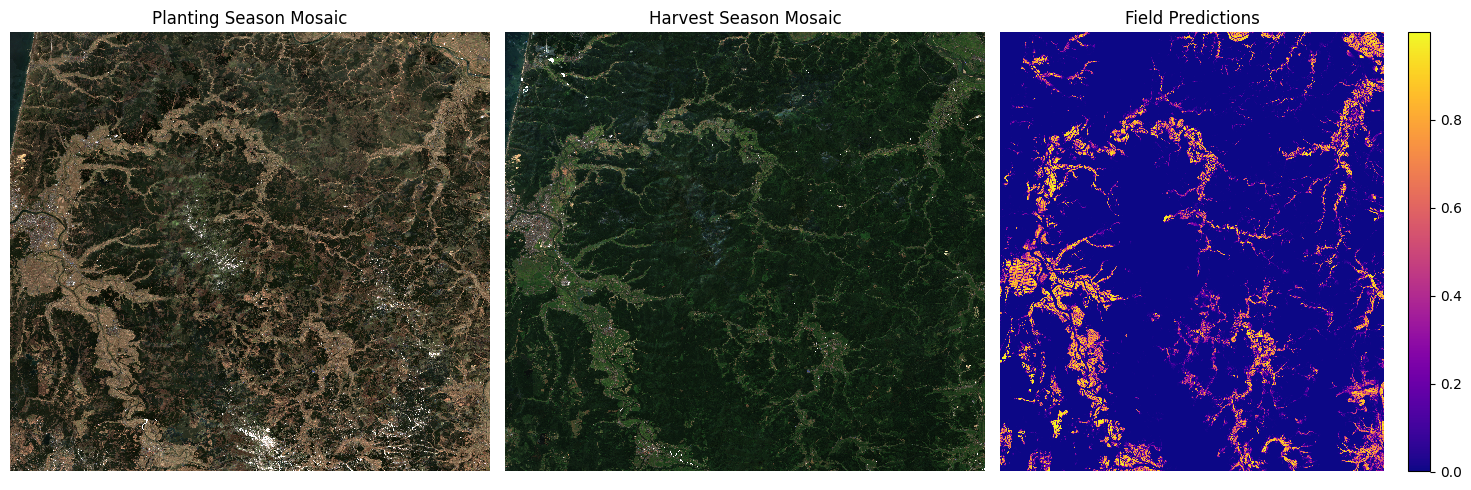

In [4]:
time = "2024-01-01"

p_crop = mosaic.sel(time=time, band=planting_bands).rio.clip_box(*aoi.geometry.total_bounds) / norm
h_crop = mosaic.sel(time=time, band=harvest_bands).rio.clip_box(*aoi.geometry.total_bounds) / norm
pred_crop = predictions.sel(time=time, band="field").rio.clip_box(*aoi.geometry.total_bounds)

p_crop = p_crop.clip(0, 1).to_array().squeeze()
h_crop = h_crop.clip(0, 1).to_array().squeeze()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

p_crop.plot.imshow(ax=axes[0])
axes[0].axis("off")
axes[0].set_title("Planting Season Mosaic")

h_crop.plot.imshow(ax=axes[1])
axes[1].axis("off")
axes[1].set_title("Harvest Season Mosaic")

pred_crop.to_array().squeeze().plot.imshow(ax=axes[2], cmap="plasma")
axes[2].axis("off")
axes[2].set_title("Field Predictions")

plt.tight_layout()
plt.show()

### 4. Convert to Cloud-Optimized GeoTIFF (COG)

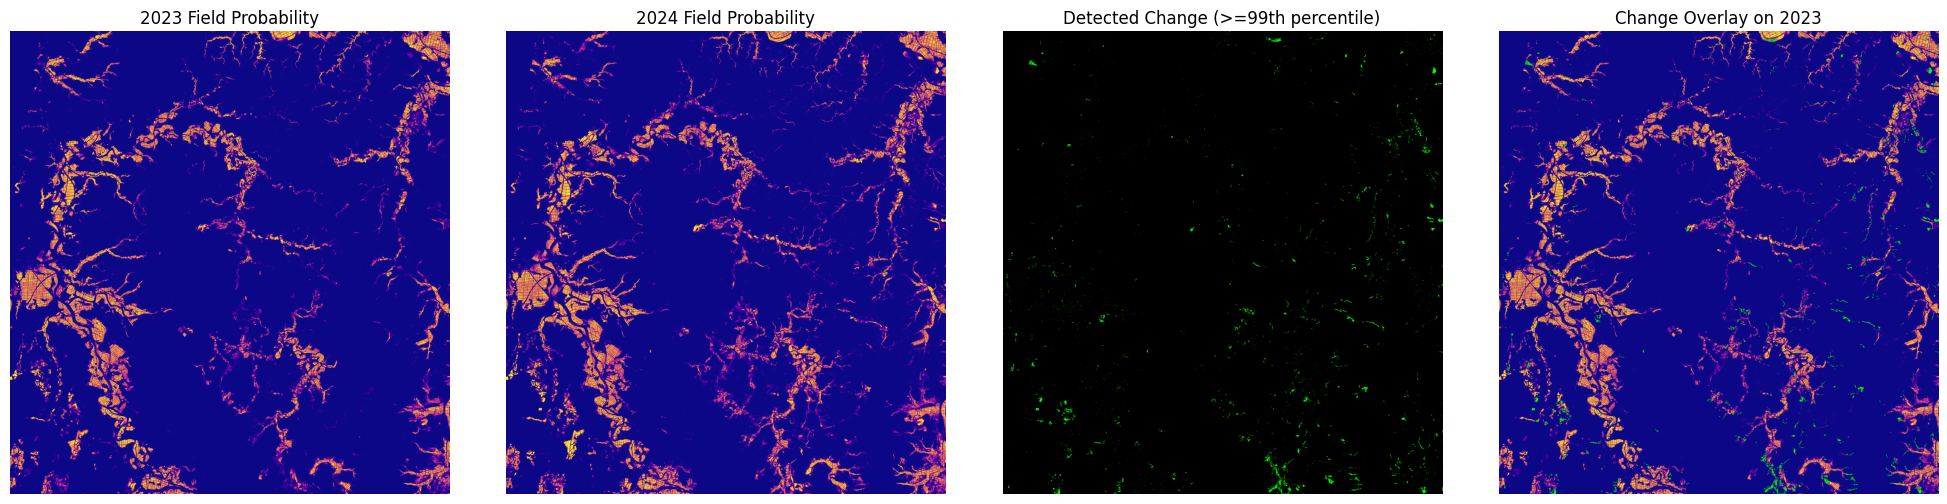

In [5]:
# Fetch predictions for both years
pred_2023 = predictions.sel(time="2023-01-01", band="field")
pred_2023 = pred_2023.rio.clip_box(*aoi.geometry.total_bounds).to_array().squeeze().to_numpy()

pred_2024 = predictions.sel(time="2024-01-01", band="field")
pred_2024 = pred_2024.rio.clip_box(*aoi.geometry.total_bounds).to_array().squeeze().to_numpy()

# Calculate difference
diff = pred_2024 - pred_2023

# Simple thresholding (>= 99th percentile)
pct = 99
threshold = np.percentile(diff[diff > 0], pct)
change = diff.clip(0, 1)
change[change >= threshold] = 1
change[change < threshold] = 0

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(pred_2023, vmin=0, vmax=1, cmap="plasma")
axes[0].set_title("2023 Field Probability")
axes[0].axis("off")

axes[1].imshow(pred_2024, vmin=0, vmax=1, cmap="plasma")
axes[1].set_title("2024 Field Probability")
axes[1].axis("off")

green_cmap = plt.cm.colors.ListedColormap([[0, 0, 0], [0, 1, 0]])
axes[2].imshow(change, vmin=0, vmax=1, cmap=green_cmap)
axes[2].set_title("Detected Change (>=99th percentile)")
axes[2].axis("off")

img = plt.cm.plasma(pred_2023)
img[change == 1, :3] = [0, 1, 0]
axes[3].imshow(img, vmin=0, vmax=1)
axes[3].set_title("Change Overlay on 2023")
axes[3].axis("off")

plt.tight_layout()
plt.show()